In [1]:
import sys
import torch
from xitorch.optimize import rootfinder
import matplotlib.pyplot as plt

sys.path.append('..')
from hijacobi import Task, Spherically_Symmetric, reparam

14:25:02|TQ-WARNING| Error enabling CUDA. cuda.is_available() returned False. CPU will be used.
/home/alexey/.local/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
# Setting model
metric_f = lambda r: 1-2/r
BH = Spherically_Symmetric(f=metric_f)

# Setting up solver
Solver0 = reparam(BH)
Solver0.set_Simpson()
Solver0.setup(2.4, 1e-4, 40, 31)
Solver0.setCustomIth(BH.Ith)

# Setting up task
th_s = torch.pi/2
th_obs = torch.pi/5

r_s = torch.Tensor([2.1, 2.4, 2.8, 3, 3.5, 5, 8, 9])
r_obs = 50

ic_0 = torch.Tensor([[[th_s, th_obs], [r_, r_obs]]for r_ in r_s ])

Task0 = Task(BH, [[0, 0, ic_0]])
Task0.set_solver(Solver0)

Test passed, setting fuction as Ith


/home/alexey/.local/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


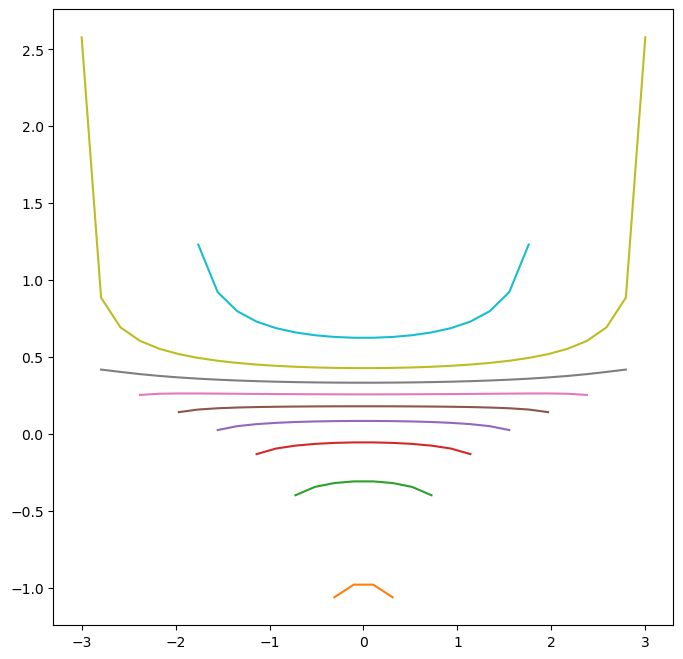

In [3]:
# Проверка отладочных функций решателя

eq0 = Task0.make_eq(0, 0)

l_s = torch.linspace(-3, 3, 30)
q_s = torch.linspace(0.1, 5.1, 10)

l_grid, q_grid = torch.meshgrid(l_s, q_s, indexing='ij')

Solver0.debugTrLQ_f(eq0, l_s, l_grid, q_grid)

In [4]:
# Проверка импортированного решателя на единичной задаче:
gma = torch.Tensor([torch.pi])

eq00 = Task0.make_eq(0, 0)
eq_p = lambda p: eq00(Solver0.L(gma, abs(p)), Solver0.Q(gma, abs(p)))

rf = Solver0.get_rootfinder()
p_res = rf(eq_p, torch.Tensor([1]))
err = eq00(Solver0.L(gma, p_res), Solver0.Q(gma, p_res))
print('Found p = ', p_res, '; err = ', err)

Found p =  tensor([0.4457]) ; err =  tensor([5.9605e-08])


/home/alexey/.local/lib/python3.11/site-packages/torchquad/integration/utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


In [5]:
# Провекра решателя на многомерной задаче:
q0 = torch.linspace(0.1, 7.1, 15)
l_s = torch.zeros_like(q0)
q_res = torch.nan*l_s
err = torch.ones_like(q0)
eq00 = Task0.make_eq(0, 0)

for i, _ in enumerate(q_res):
    eq_q = lambda q: eq00(l_s[i], abs(q))
    q_res[i] = rootfinder(eq_q, q0[i])
    err[i] = eq00(l_s[i], q_res[i])

print('Found q:\n', q_res, '\nerr\n', err)

ValueError: Jacobian inversion yielded zero vector. This indicates a bug in the Jacobian approximation.

In [6]:
# Сравним решение с отбором траекторий по ошибке и без него

gma_s = torch.linspace(-1, 1, 30)*torch.pi
p0 = torch.Tensor([1])
p_s = torch.ones_like(gma_s)
err = torch.ones_like(gma_s)

eq00 = Task0.make_eq(0,0)

for i, gma in enumerate(gma_s):
    eq_p = lambda p: eq00(Solver0.L(gma, torch.abs(p)), Solver0.Q(gma, torch.abs(p)))
    p_s[i] = rootfinder(eq_p, p0, maxiter=80)


l_s = Solver0.L(gma_s, p_s)
q_s = Solver0.Q(gma_s, p_s)

err = eq00(l_s, q_s)
er0 = torch.zeros_like(err)
mask1 = torch.isclose(err, er0, atol = 1e-6)
mask2 = torch.isclose(err, er0, atol = 1e-4)
mask3 = torch.isclose(err, er0, atol = 1e-2)
print(err)


/home/alexey/.local/lib/python3.11/site-packages/xitorch/_impls/optimize/root/rootsolver.py:165: ConvergenceWarning: The rootfinder does not converge after 80 iterations. Best |dx|=5.000e-01, |f|=3.289e-02 at iter 1
  warnings.warn(ConvergenceWarning(msg))
/home/alexey/.local/lib/python3.11/site-packages/xitorch/_impls/optimize/root/rootsolver.py:165: ConvergenceWarning: The rootfinder does not converge after 80 iterations. Best |dx|=1.000e+00, |f|=1.206e-01 at iter 0
  warnings.warn(ConvergenceWarning(msg))
/home/alexey/.local/lib/python3.11/site-packages/xitorch/_impls/optimize/root/rootsolver.py:165: ConvergenceWarning: The rootfinder does not converge after 80 iterations. Best |dx|=2.011e+00, |f|=1.093e-01 at iter 3
  warnings.warn(ConvergenceWarning(msg))
/home/alexey/.local/lib/python3.11/site-packages/xitorch/_impls/optimize/root/rootsolver.py:165: ConvergenceWarning: The rootfinder does not converge after 80 iterations. Best |dx|=1.000e+00, |f|=1.906e-01 at iter 0
  warnings.wa

tensor([ 0.0000e+00, -5.9605e-08,  2.9802e-08,  2.3842e-07, -8.9407e-08,
         5.9605e-08, -1.7881e-07,  3.2893e-02,  1.2059e-01,  8.9595e-02,
         1.9056e-01,  2.1539e-01, -1.3233e-01, -1.3783e-01, -1.4102e-01,
        -1.4102e-01, -1.3783e-01, -1.3233e-01,  2.1539e-01,  1.9056e-01,
         8.9595e-02,  1.2059e-01,  3.2893e-02, -1.7881e-07,  5.9605e-08,
        -8.9407e-08,  2.3842e-07,  2.9802e-08, -5.9605e-08,  0.0000e+00])


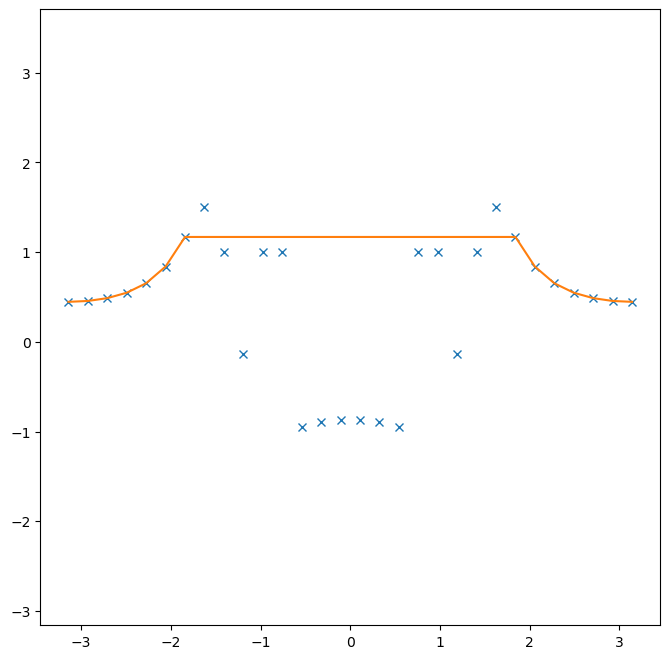

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(gma_s, p_s, 'x')
ax.plot(gma_s[mask1], p_s[mask1])
ax.axis('equal')
plt.show()

## Тестируем итоговую версию решателя

In [3]:
eq00 = Task0.make_eq(0, 0)

eq_p = lambda p, gma: eq00(Solver0.L(gma, abs(p)), Solver0.Q(gma, abs(p)))

gma0 = torch.linspace(0, 2, 24)*torch.pi
p0 = torch.ones_like(gma0)

gma_res, p_res, err = Solver0.solve(eq_p, gma0, p0, 3)

/home/alexey/.local/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/alexey/.local/lib/python3.11/site-packages/torchquad/integration/utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(
/home/alexey/.local/lib/python3.11/site-packages/xitorch/_impls/optimize/root/rootsolver.py:165: ConvergenceWarning: The rootfinder does not converge after 40 iterations. Best |dx|=2.371e+00, |f|=2.355e-01 at iter 2
  warnings.warn(ConvergenceWarning(msg))
/home/alexey/.local/lib/python3.11/site-packages/xitorch/_impls/optimize/root/rootsolver.py:165: ConvergenceWarning: The rootfinder does not converge after 40 iterations. Best |dx|=2.390e+00, |f|=2.337e-01 at iter 

ValueError: Jacobian inversion yielded zero vector. This indicates a bug in the Jacobian approximation.

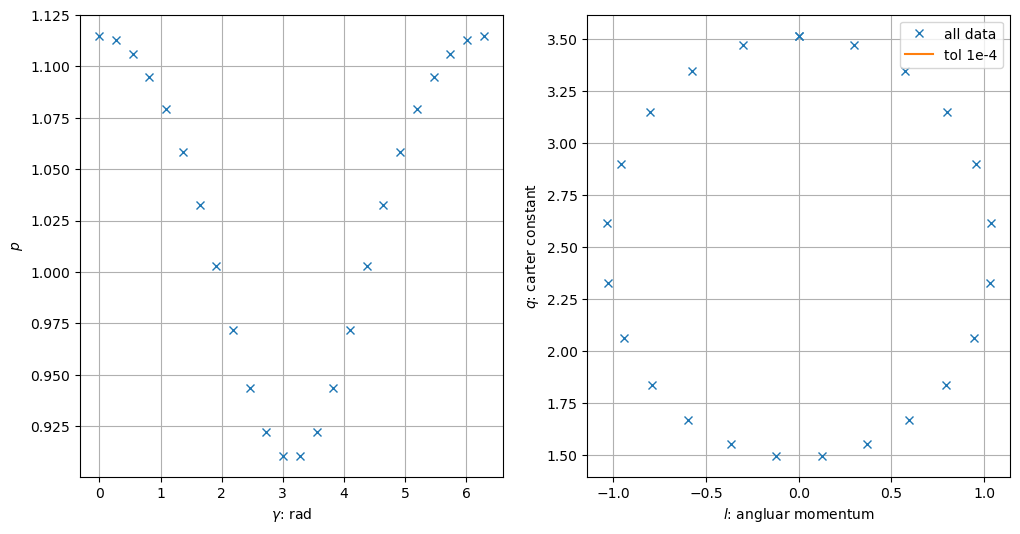

In [10]:
mask_t = torch.less(abs(err), 1e-4)

p_true = torch.nan*torch.ones_like(gma_res)
p_true[mask_t] = p_res[mask_t]

l_all = Solver0.L(gma_res, p_res)
q_all = Solver0.Q(gma_res, p_res)

l_true = Solver0.L(gma_res, p_true)
q_true= Solver0.Q(gma_res, p_true)

fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(gma_res, p_res, 'x')
ax[0].plot(gma_res, p_true)
ax[0].set_xlabel('$\gamma$: rad')
ax[0].set_ylabel('$p$')
ax[0].grid('on')

ax[1].plot(l_all, q_all, 'x')
ax[1].plot(l_true, q_true)
ax[1].set_xlabel('$l$: angluar momentum')
ax[1].set_ylabel('$q$: carter constant')
ax[1].legend(['all data', 'tol 1e-4'], )
ax[1].grid('on')

plt.show()